# Clasificación de sentimientos utilizando LSTM y Keras

La clasificación del dataset de sentimientos fue realizada teniendo como guía [este artículo.](https://medium.datadriveninvestor.com/deep-learning-lstm-for-sentiment-analysis-in-tensorflow-with-keras-api-92e62cde7626) Por otra parte se realizó la clasificación de sentimientos utlizando las noticias procesadas y sin procesar.

In [85]:
import pandas as pd
import numpy as np
df = pd.read_csv("https://raw.githubusercontent.com/Mentoria-Financiera-DiploDatos/Entrega3/master/sentimientos/data/feeling_procesado.csv")
print(df.news.size)
df.head(8)

4838


,Unnamed: 0,feeling,news,news_tokens,news_tokens_tagged
0,0,neutral,"According to Gran , the company has no plans t...","['accord', 'gran', 'company', 'plan', 'move', ...","[('accord', 'NN'), ('gran', 'VBD'), ('company'..."
1,1,neutral,Technopolis plans to develop in stages an area...,"['technopolis', 'plan', 'develop', 'stage', 'a...","[('technopolis', 'NN'), ('plan', 'NN'), ('deve..."
2,2,negative,The international electronic industry company ...,"['international', 'electronic', 'industry', 'c...","[('international', 'JJ'), ('electronic', 'JJ')..."
3,3,positive,With the new production plant the company woul...,"['new', 'production', 'plant', 'company', 'wou...","[('new', 'JJ'), ('production', 'NN'), ('plant'..."
4,4,positive,According to the company 's updated strategy f...,"['accord', 'company', 'update', 'strategy', 'y...","[('accord', 'NN'), ('company', 'NN'), ('update..."
5,5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"['finance', 'aspocomp', 'growth', 'aspocomp', ...","[('finance', 'NN'), ('aspocomp', 'NN'), ('grow..."
6,6,positive,"For the last quarter of 2010 , Componenta 's n...","['last', 'quarter', 'componenta', 'net', 'sale...","[('last', 'JJ'), ('quarter', 'NN'), ('componen..."
7,7,positive,"In the third quarter of 2010 , net sales incre...","['third', 'quarter', 'net', 'sale', 'increase'...","[('third', 'JJ'), ('quarter', 'NN'), ('net', '..."


Se aleatorizaron las filas para remover el agrupamiento dado por la columna ´feeling´ y así evitar problemas al entrenar el modelo.

In [86]:
# Mezclamos con sample ya que los sentimientos están bastante agrupados en el
#  dataset y esto genera problemas luego a la hora de entrenar el modelo.
df = df.sample(frac=1, random_state=0).reset_index(drop=True)
df.head(8)

,Unnamed: 0,feeling,news,news_tokens,news_tokens_tagged
0,2343,neutral,"Raute , headquartered in Nastola , Finland , i...","['raute', 'headquarter', 'nastola', 'finland',...","[('raute', 'NN'), ('headquarter', 'NN'), ('nas..."
1,2803,positive,"And earlier this month , the company signed a ...","['early', 'month', 'company', 'sign', 'deal', ...","[('early', 'JJ'), ('month', 'NN'), ('company',..."
2,3825,neutral,The divested activities had net sales of EUR 1...,"['divest', 'activity', 'net', 'sale', 'eur', '...","[('divest', 'JJS'), ('activity', 'NN'), ('net'..."
3,4437,negative,`` We can say that the number of deals has bec...,"['say', 'number', 'deal', 'become', 'normalize...","[('say', 'VB'), ('number', 'NN'), ('deal', 'NN..."
4,4802,neutral,The manager is critical of politicians ' failu...,"['manager', 'critical', 'politician', 'failure...","[('manager', 'NN'), ('critical', 'JJ'), ('poli..."
5,3575,neutral,"Eero Katajavuori , currently Group Vice Presid...","['eero', 'katajavuori', 'currently', 'group', ...","[('eero', 'NN'), ('katajavuori', 'NNS'), ('cur..."
6,849,positive,"However , the broker gave an `` outperform '' ...","['however', 'broke', 'give', 'outperform', 're...","[('however', 'RB'), ('broke', 'VBD'), ('give',..."
7,2374,negative,Finnish plumbing and heating systems supplier ...,"['finnish', 'plumb', 'heat', 'system', 'suppli...","[('finnish', 'JJ'), ('plumb', 'NN'), ('heat', ..."


Se remueve aquellas etiquetadas con´neutral´ para obtener mejores resultados en la clasificación. Además, se había observado previamente en [´03_ML_TFidf.ipynb´](https://github.com/Mentoria-Financiera-DiploDatos/Entrega3/blob/master/sentimientos/03_ML_TFidf.ipynb), algunas de las palabras mas asociadas a sentimiento ´neutral´ también fueron palabras asociadas al resto de los sentimiento (ej. rise y loss).

In [87]:
# convert feeling to numeric
df = df[df['feeling'] != 'neutral'].reset_index(drop=True)
print(df.feeling.size)

1966


## Noticias no procesadas

Se seleccionan las columnas de interés.

In [88]:
news_df = df[['feeling', 'news']]

In [89]:
news_df.head(8)

,feeling,news
0,positive,"And earlier this month , the company signed a ..."
1,negative,`` We can say that the number of deals has bec...
2,positive,"However , the broker gave an `` outperform '' ..."
3,negative,Finnish plumbing and heating systems supplier ...
4,negative,"ADPnews - Sep 28 , 2009 - Finnish silicon wafe..."
5,positive,Net sales went up by 1 % year-on-year to EUR 2...
6,positive,The District Court of Helsinki dismissed all c...
7,positive,"Net sales totaled EUR 93.6 mn , up from EUR 93..."


In [90]:
# Convert feeling to numeric
sentiment_label = news_df.feeling.factorize()

In [91]:
contador = 0
for i in range(news_df.news.size):
    temp_list = news_df.news[i].split()
    temp_contador = 0
    for j in temp_list:
        temp_contador+=1
    if temp_contador>contador:
        contador = temp_contador

contador

57

Se tokenizan las noticias y se las tranforman a un numpy.array para poder ser luego ingresado dentro de la red neuronal. Utilizamos un maxlen de 60 ya que con los textos sin preprocesar la noticia con más palabras tiene 57 palabras.

In [92]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

news = news_df.news.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(news)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(news)
padded_sequence = pad_sequences(encoded_docs, maxlen=60)

Se transformaron los indices de cada palabra que estaban en un diccionario en un dataframe para visualizar que los _stopwords_ no fueron removidos.

In [93]:
tokens= pd.DataFrame.from_dict(tokenizer.word_index, orient='index', columns=['num'])
tokens.head(10)

,num
the,1
in,2
of,3
to,4
and,5
eur,6
a,7
from,8
for,9
mn,10


In [94]:
print("Palabras con las noticias sin el preprocesado:", vocab_size)

Palabras con las noticias sin el preprocesado: 5535


In [95]:
print(news[0])
print(encoded_docs[0])

And earlier this month , the company signed a deal with India-based information technology services giant Wipro Technologies to transfer and sell its radio access related R&D activities in Berlin .
[5, 91, 80, 139, 1, 13, 100, 7, 347, 26, 440, 128, 441, 94, 84, 2613, 2614, 567, 4, 994, 5, 678, 14, 1156, 1400, 568, 760, 761, 762, 2, 2615]


In [96]:
print(padded_sequence[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    5   91   80  139    1   13  100    7  347   26  440  128  441
   94   84 2613 2614  567    4  994    5  678   14 1156 1400  568  760
  761  762    2 2615]


  Con el fin de obtener también las métricas de _recall_, _precision_ y _f1_ se definieron las siguientes funciones y luego se los incluyo en el modelo final.

In [97]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [98]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=60) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])  
print(model.summary()) 


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 60, 32)            177120    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 60, 32)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 193,771
Trainable params: 193,771
Non-trainable params: 0
_________________________________________________________________
None


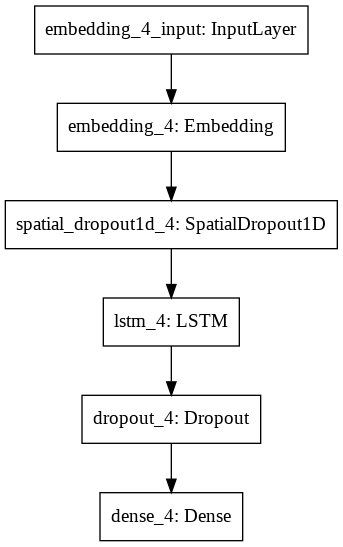

In [99]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [100]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=8, batch_size=32)

Epoch 1/8
50/50 [==============================] - 8s 82ms/step - loss: 0.6267 - acc: 0.6877 - f1_m: 0.0283 - precision_m: 0.0425 - recall_m: 0.0301 - val_loss: 0.6267 - val_acc: 0.6878 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/8
50/50 [==============================] - 4s 75ms/step - loss: 0.5849 - acc: 0.6953 - f1_m: 0.0272 - precision_m: 0.1000 - recall_m: 0.0160 - val_loss: 0.5529 - val_acc: 0.7056 - val_f1_m: 0.1387 - val_precision_m: 0.4615 - val_recall_m: 0.0896
Epoch 3/8
50/50 [==============================] - 4s 73ms/step - loss: 0.4168 - acc: 0.8104 - f1_m: 0.5675 - precision_m: 0.7821 - recall_m: 0.5058 - val_loss: 0.4901 - val_acc: 0.7868 - val_f1_m: 0.5871 - val_precision_m: 0.7510 - val_recall_m: 0.5140
Epoch 4/8
50/50 [==============================] - 4s 74ms/step - loss: 0.2809 - acc: 0.9008 - f1_m: 0.8194 - precision_m: 0.8328 - recall_m: 0.8232 - val_loss: 0.5113 - val_acc: 0.7970 - val_f1_m: 0.6114 - val_precision_m: 0.

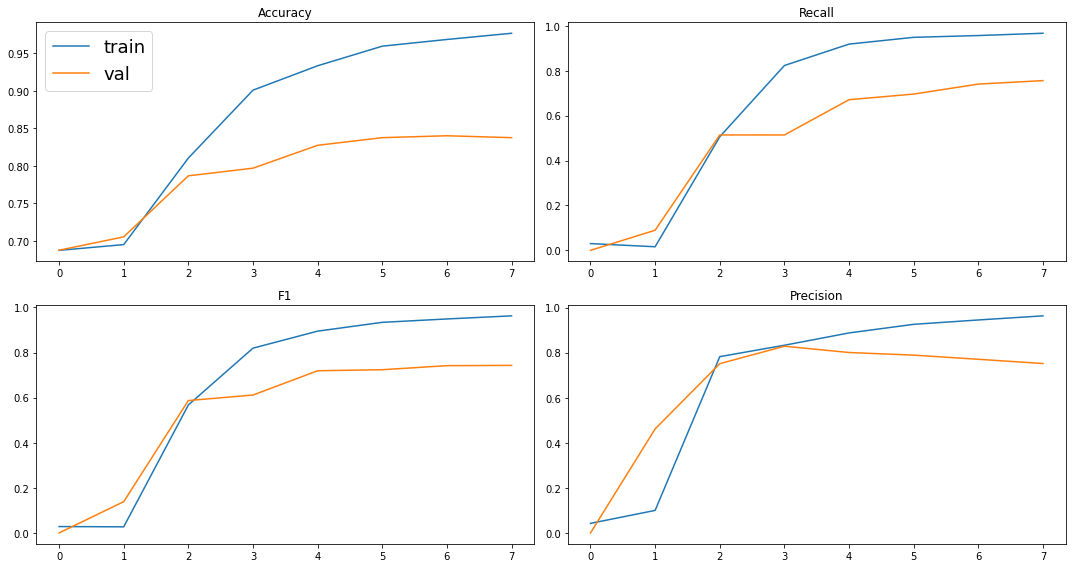

In [101]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15,8))
axs[0, 0].plot(history.history['acc'], label='train')
axs[0, 0].plot(history.history['val_acc'], label='val')
axs[0, 0].set_title("Accuracy")
axs[0, 0].legend(prop={'size': 18})
axs[1, 0].plot(history.history['f1_m'])
axs[1, 0].plot(history.history['val_f1_m'])
axs[1, 0].set_title("F1")

axs[0, 1].plot(history.history['recall_m'])
axs[0, 1].plot(history.history['val_recall_m'])
axs[0, 1].set_title("Recall")

axs[1, 1].plot(history.history['precision_m'])
axs[1, 1].plot(history.history['val_precision_m'])
axs[1, 1].set_title("Precision")

fig.tight_layout()

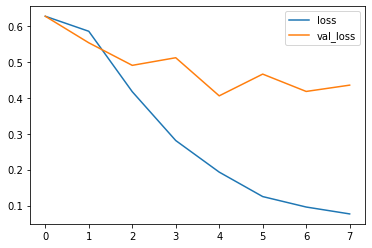

In [102]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [103]:
newsVanillaAcc = history.history['val_acc']
newsVanillaLoss = history.history['val_loss']
newsVanillaF1 = history.history['val_f1_m']
newsVanillaRecall = history.history['val_recall_m']

In [104]:
test_word = "This is bad, negative, a tax, horrible. Please classify me as negative!"
tw = tokenizer.texts_to_sequences([test_word])
tw

[[80, 34, 332, 7, 472, 42, 332]]

In [105]:
tw = pad_sequences(tw,maxlen=60)
prediction = int(model.predict(tw).round().item())

In [106]:
sentiment_label[1][prediction]

'positive'

In [107]:
test_word_2= "I told she is not happy"
tw_2 = tokenizer.texts_to_sequences([test_word_2])
tw_2

[[428, 637, 1933, 34, 431, 962]]

In [108]:
tw_2 = pad_sequences(tw_2,maxlen=60)
prediction_2 = int(model.predict(tw_2).round().item())

In [109]:
sentiment_label[1][prediction_2]

'positive'

# Probando con ´news_tokens´

A continuación generamos a partir de `news_tokens` una columna `news_tokens_str` que tiene las noticias con el texto preprocesado pero en string para luego cargarlas de esta forma que resulta conveniente.

In [110]:
df['news_tokens_str'] = df.news
for i in range(df.news_tokens.size):
    temp_list = df.news_tokens[i].split()
    temp_str = ""
    for j in temp_list:
        temp_str += j.replace("[", '').replace("]", '').replace("'", '').replace(",", ' ')
    df.news_tokens_str.values[i] = temp_str

Se seleccionan las columnas de interés.

In [111]:
news_proc = df[['feeling', 'news_tokens_str']]

In [112]:
news_proc.head(8)

,feeling,news_tokens_str
0,positive,early month company sign deal indiabased infor...
1,negative,say number deal become normalize moment theref...
2,positive,however broke give outperform recommendation s...
3,negative,finnish plumb heat system supplier uponor temp...
4,negative,adpnews sep finnish silicon wafer maker okmeti...
5,positive,net sale go yearonyear eur million affect busi...
6,positive,district court helsinki dismiss charge court f...
7,positive,net sale total eur mn eur mn correspond period


In [113]:
# Convert feeling to numeric
sentiment_label_proc = news_proc.feeling.factorize()

Se tokenizan las noticias y se las tranforman a un numpy.array para poder ser luego ingresado dentro de la red neuronal. Utilizamos un maxlen de 40 ya que con los textos preprocesados la noticia con más palabras tiene 38 palabras.

In [114]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

news = news_proc.news_tokens_str.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(news)
vocab_size_proc = len(tokenizer.word_index) + 1
encoded_docs_proc = tokenizer.texts_to_sequences(news)
padded_sequence_proc = pad_sequences(encoded_docs_proc, maxlen=40)

In [115]:
print("Palabras con las noticias preprocesadas:", vocab_size_proc)

Palabras con las noticias preprocesadas: 4082


In [116]:
print(news[0])
print(encoded_docs_proc[0])

early month company sign deal indiabased information technology service giant wipro technology transfer sell radio access relate rd activity berlin
[44, 46, 3, 50, 205, 1932, 341, 42, 27, 1933, 1934, 42, 668, 206, 880, 1042, 669, 758, 533, 1935]


In [117]:
print(padded_sequence_proc[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0   44   46    3   50  205 1932  341   42
   27 1933 1934   42  668  206  880 1042  669  758  533 1935]


In [118]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size_proc, embedding_vector_length, input_length=40) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])  
print(model.summary()) 


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 32)            130624    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 40, 32)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 147,275
Trainable params: 147,275
Non-trainable params: 0
_________________________________________________________________
None


In [119]:
history_proc = model.fit(padded_sequence_proc,sentiment_label_proc[0],validation_split=0.2, epochs=8, batch_size=32)

Epoch 1/8
50/50 [==============================] - 6s 56ms/step - loss: 0.6418 - acc: 0.6838 - f1_m: 0.0102 - precision_m: 0.0088 - recall_m: 0.0124 - val_loss: 0.6177 - val_acc: 0.6878 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/8
50/50 [==============================] - 2s 49ms/step - loss: 0.5828 - acc: 0.6959 - f1_m: 0.0179 - precision_m: 0.0500 - recall_m: 0.0125 - val_loss: 0.5704 - val_acc: 0.7056 - val_f1_m: 0.2459 - val_precision_m: 0.6282 - val_recall_m: 0.1582
Epoch 3/8
50/50 [==============================] - 2s 48ms/step - loss: 0.4266 - acc: 0.7996 - f1_m: 0.5507 - precision_m: 0.7572 - recall_m: 0.4656 - val_loss: 0.5948 - val_acc: 0.7640 - val_f1_m: 0.5123 - val_precision_m: 0.7485 - val_recall_m: 0.4157
Epoch 4/8
50/50 [==============================] - 2s 48ms/step - loss: 0.2773 - acc: 0.8874 - f1_m: 0.7905 - precision_m: 0.8214 - recall_m: 0.7758 - val_loss: 0.5302 - val_acc: 0.7970 - val_f1_m: 0.6804 - val_precision_m: 0.

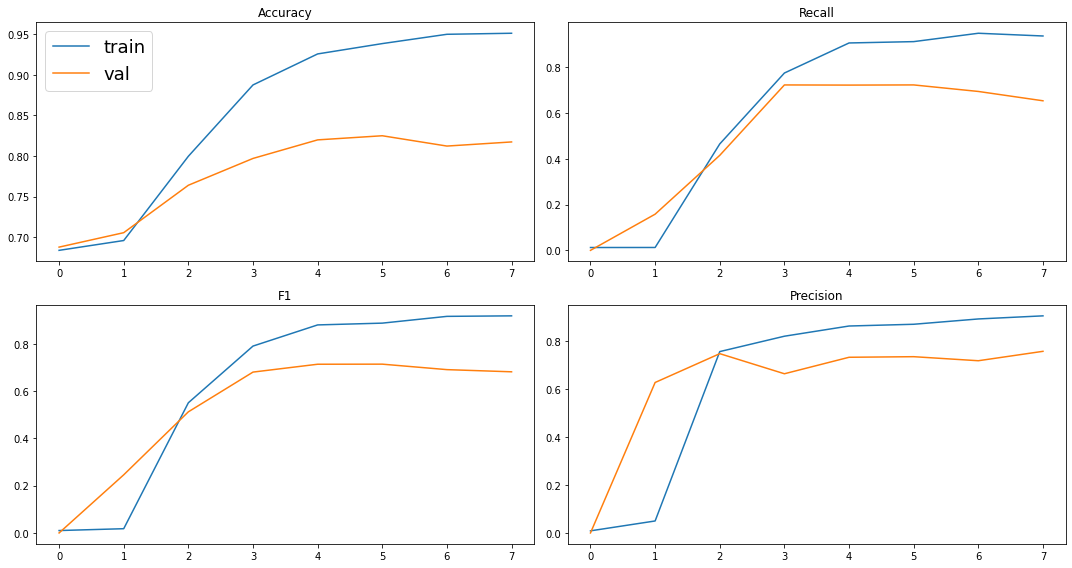

In [120]:
fig, axs = plt.subplots(2, 2, figsize=(15,8))
axs[0, 0].plot(history_proc.history['acc'], label='train')
axs[0, 0].plot(history_proc.history['val_acc'], label='val')
axs[0, 0].set_title("Accuracy")
axs[0, 0].legend(prop={'size': 18})

axs[1, 0].plot(history_proc.history['f1_m'])
axs[1, 0].plot(history_proc.history['val_f1_m'])
axs[1, 0].set_title("F1")

axs[0, 1].plot(history_proc.history['recall_m'])
axs[0, 1].plot(history_proc.history['val_recall_m'])
axs[0, 1].set_title("Recall")

axs[1, 1].plot(history_proc.history['precision_m'])
axs[1, 1].plot(history_proc.history['val_precision_m'])
axs[1, 1].set_title("Precision")

fig.tight_layout()

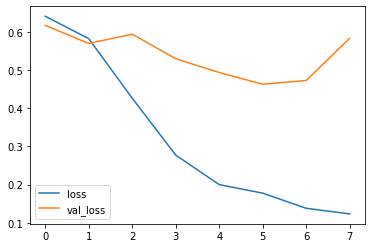

In [121]:
plt.plot(history_proc.history['loss'], label='loss')
plt.plot(history_proc.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [122]:
tokensNewsAcc = history_proc.history['val_acc']
tokensNewsLoss = history_proc.history['val_loss']
tokensNewsF1 = history_proc.history['val_f1_m']
tokensNewsRecall = history_proc.history['val_recall_m']

In [123]:
test_word = "This is bad, negative, a tax, horrible. Please classify me as negative!"
tw = tokenizer.texts_to_sequences([test_word])
tw

[[3740, 244, 189, 391, 244]]

In [124]:
tw = pad_sequences(tw,maxlen=40)
prediction = int(model.predict(tw).round().item())

In [125]:
sentiment_label_proc[1][prediction]

'positive'

Suponiendo que tenemos libertad en el consumo de recursos, utilizaremos para comparar los modelos la 6ta época del primero de ellos (con noticias sin preprocesamiento) y la 3ra época del modelo que predijo sobre los tokens procesados. Los valores son evaluados sobre el conjunto de Validación.


In [126]:
print("---------------------------------------------------------------")
print("                       |", "Val Loss", "|", "Accuracy", "|", "F1", "    |", "Recall", "|")
print("---------------------------------------------------------------|")
print("Model News Vanilla    ", "|", np.round(newsVanillaLoss[7],3), "   |", np.round(newsVanillaAcc[7],3), "   |", np.round(newsVanillaF1[7],3), " |", np.round(newsVanillaRecall[7],3), " |")
print("Model with Tokens News", "|", np.round(tokensNewsLoss[7],3), "   |", np.round(tokensNewsAcc[7],3), "   |", np.round(tokensNewsF1[7],3), " |", np.round(tokensNewsRecall[7], 3)," |" )
print("---------------------------------------------------------------")

---------------------------------------------------------------
                       | Val Loss | Accuracy | F1     | Recall |
---------------------------------------------------------------|
Model News Vanilla     | 0.435    | 0.838    | 0.743  | 0.756  |
Model with Tokens News | 0.584    | 0.817    | 0.682  | 0.654  |
---------------------------------------------------------------


## Conclusiones

Se obtuvieron mejores resultados en las diferentes métricas para el modelo entrenado con las noticias sin procesar. Esto puede deberse a que este datset posee _stopwords_ que podrían ser necesarios para la clasificación de los sentimientos. En este sentido, algunos autores mencionan que dependiendo del objetivo de la clasificación puede no ser conveniente la remoción de  _stopwords_ Por lo que se sugiere, realizar el entrenamiento y evaluación del modelo con y sin _stopwords_ y ver las diferencia en los resultados, tal como se realizó previamente. En el caso particular de la clasificación de los sentimientos, suele ocurrir que la remoción de _stopwords_ no suele dar buenos resultados dado que los mismos pueden ayudar a otorgar sentido y significado a la hora de predecir un documento a un cierto sentimiento (ver [este artículo](https://medium.com/@limavallantin/why-is-removing-stop-words-not-always-a-good-idea-c8d35bd77214)). De acuerdo a los resultados obtenidos, conviene realizar las predicciones de sentimientos de noticias con el modelo entrenado con noticias sin procesar. Además quedaría pendiente analizar si los resultados pueden ser mejorados utilizando una nueva lista de _stopwords_ dadas por spaCy, Gensim o incluso generar una lista propia (ver [este artículo](https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a))

Respecto a los valores de las métricas obtenidos se observa que para ambos casos, el valor de accuracy es similar a diferencia del resto de las métricas. Para la clasificación con las noticias procesadas (´news_tokens´) se obtuvieron bajos valores de F1, recall y precision, lo cual indicaría la dificultad en clasificar las noticias con sentimiento negativo que es la clase minoritaria. El valor de accuracy no varía significativamente probablemente debido a que esta métrica le da mayor importancia a la clase mayoritaria que en este caso es el sentimiento positivo.